**Recovering bonds from structure**

This kernel presents a method to extract the bonds between atoms in a molecule.  The inputs are the XYZ coordinates of the atoms (as found in the given structure data) and the covalent radius for each element (from wikipedia).  The output is, for each atom, a list of atom_indexes of the other atoms that it is bonded to.  The method is similar to the atomic connectivity step described here: http://proteinsandwavefunctions.blogspot.com/2018/01/xyz2mol-converting-xyz-file-to-rdkit.html.

In [32]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
%matplotlib inline
print(os.listdir("../input"))

KAGGLE_DIR = '../input'

# Atom level properties
MULLIKEN_CHARGES_CSV = os.path.join(KAGGLE_DIR, 'mulliken_charges.csv')
SCALAR_COUPLING_CONTRIBUTIONS_CSV = os.path.join(KAGGLE_DIR, 'scalar_coupling_contributions.csv')
MAGNETIC_SHIELDING_TENSORS_CSV = os.path.join(KAGGLE_DIR, 'magnetic_shielding_tensors.csv')
STRUCTURES_CSV = os.path.join(KAGGLE_DIR, 'structures.csv')

# Molecule level properties
POTENTIAL_ENERGY_CSV = os.path.join(KAGGLE_DIR, 'potential_energy.csv')
DIPOLE_MOMENTS_CSV = os.path.join(KAGGLE_DIR, 'dipole_moments.csv')

# Atom-Atom interactions
TRAIN_CSV = os.path.join(KAGGLE_DIR, 'train.csv')
TEST_CSV = os.path.join(KAGGLE_DIR, 'test.csv')

['potential_energy.csv', 'mulliken_charges.csv', 'train.csv', 'scalar_coupling_contributions.csv', 'sample_submission.csv', 'structures', 'test.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'structures.csv']


**Read and preprocess structure data**

The most important step here for bond detection is the addition of the atomic radius values.  There are several different definitions of atomic radius, but the most relevant in this situation is the radius of a single covalent bond.  Wikipedia maintains a table with this value at https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page).  I increased the values slightly in order to reduce false negatives.  Atoms that are not bonded repel each other, so it should be rare that this increase will result in false positives.

In [33]:
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

structures = pd.read_csv(STRUCTURES_CSV, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


,molecule_name,atom_index,atom,x,y,z,EN,rad
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43


**Chemical Bond Calculation**



In [34]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'bonds':bonds_numeric, 'n_bonds':n_bonds, 'bond_lengths':bond_lengths}
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

Calculating bonds



Counting and condensing bonds


,molecule_name,atom_index,atom,x,y,z,EN,rad,bonds,n_bonds,bond_lengths
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,"[1, 2, 3, 4]",4,"[1.091953, 1.0919516, 1.0919464, 1.0919476]"
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,[0],1,[1.091953]
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,[0],1,[1.0919516]
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,[0],1,[1.0919464]
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,[0],1,[1.0919476]
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.80,"[1, 2, 3]",3,"[1.01719, 1.0171872, 1.0172079]"
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.43,[0],1,[1.01719]
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.43,[0],1,[1.0171872]
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.43,[0],1,[1.0172079]
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.78,"[1, 2]",2,"[0.9621068, 0.9621068]"


**Validation**

**The last molecule - 133885**

Here is a visualization of the xyz file generated by a program called IQmol 

(Info and download here: http://iqmol.org/)

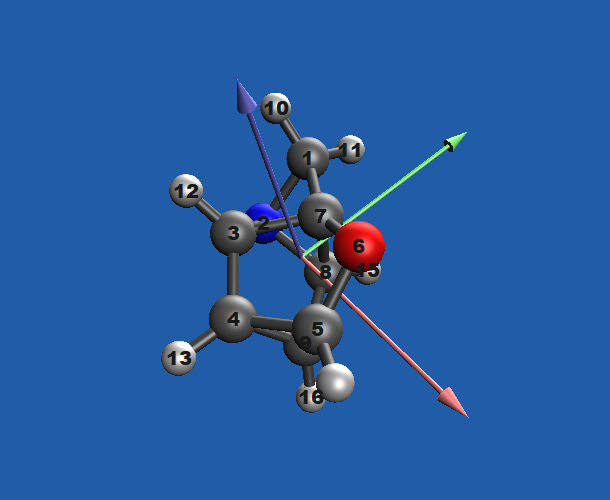

This molecule has 16 atoms.  Below are the generated bonds.  It is fairly easy to verify that the visualization program and the generated bonds agree. (Note: IQmol uses 1-index and I use 0-index)

In [35]:
structures.tail(16)

,molecule_name,atom_index,atom,x,y,z,EN,rad,bonds,n_bonds,bond_lengths
2358641,dsgdb9nsd_133885,0,C,-1.409877,1.337337,0.409953,2.55,0.82,"[1, 6, 9, 10]",4,"[1.554426, 1.5406667, 1.0918261, 1.0918262]"
2358642,dsgdb9nsd_133885,1,N,-1.564594,0.099125,-0.516941,3.04,0.80,"[0, 2, 7]",3,"[1.554426, 1.5630976, 1.5630974]"
2358643,dsgdb9nsd_133885,2,C,-0.832899,-0.707550,0.604295,2.55,0.82,"[1, 3, 6, 11]",4,"[1.5630976, 1.5032718, 1.5311829, 1.0882041]"
2358644,dsgdb9nsd_133885,3,C,0.271030,-1.618614,0.144805,2.55,0.82,"[2, 4, 8, 12]",4,"[1.5032718, 1.537739, 1.5195159, 1.0804824]"
2358645,dsgdb9nsd_133885,4,C,1.528454,-0.755123,0.339508,2.55,0.82,"[3, 5, 8, 13]",4,"[1.537739, 1.432254, 1.5377394, 1.0805514]"
2358646,dsgdb9nsd_133885,5,O,1.250213,0.458640,1.047119,3.44,0.78,"[4, 6]",2,"[1.432254, 1.4103838]"
2358647,dsgdb9nsd_133885,6,C,-0.057400,0.611210,0.541102,2.55,0.82,"[0, 2, 5, 7]",4,"[1.5406667, 1.5311829, 1.4103838, 1.5311819]"
2358648,dsgdb9nsd_133885,7,C,-0.095929,0.380424,-0.972098,2.55,0.82,"[1, 6, 8, 14]",4,"[1.5630974, 1.5311819, 1.5032722, 1.0882041]"
2358649,dsgdb9nsd_133885,8,C,0.816694,-0.813067,-1.022360,2.55,0.82,"[3, 4, 7, 15]",4,"[1.5195159, 1.5377394, 1.5032722, 1.0804824]"
2358650,dsgdb9nsd_133885,9,H,-2.090436,1.327066,1.263661,2.20,0.43,[0],1,[1.0918261]


**Bond counts by element**

Based on the number of electrons in an atom's valence shell, we know how many bonds the atom needs to form to be stable.  Hydrogen needs 1, Flourine needs 1, Oxygen needs 2, Nitrogen needs 3, and Carbon needs 4.  Bonds can be single, double, or triple, but we have not yet calculated the strength of the bonds.  Therefore there is a range of valid bond counts we could get for each atom.

- Hydrogen         
    - 1
- Flourine
    - 1
- Oxygen
    - 1 - 2
- Nitrogen         
    - 1 - 3
- Carbon   
    - 2 - 4
    
When we graph the number of bonds for each element we see that these conditions are met, with the sole exception of several Nitrogen atoms forming 4 bonds.

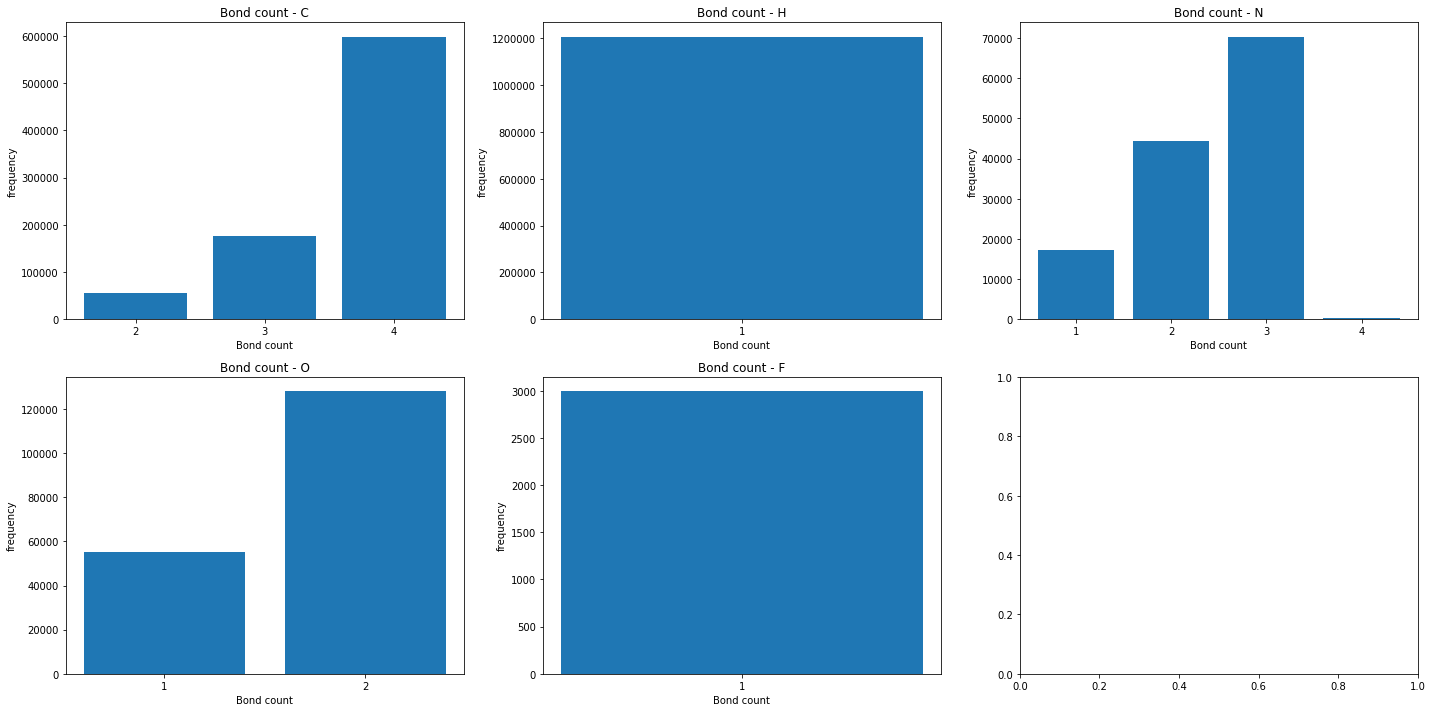

In [49]:
elements = structures['atom'].unique()
graphs_per_row = 3
row_count = int(np.ceil(len(elements) / graphs_per_row))
fig, axes = plt.subplots(row_count, graphs_per_row, figsize=(20, row_count * 5))

for i, element in enumerate(elements):
    x = structures[structures['atom'] == element].n_bonds.value_counts().index
    y = structures[structures['atom'] == element].n_bonds.value_counts().values
    ax = axes[i//graphs_per_row, i%graphs_per_row]
    ax.bar(x=x, height=y, tick_label=[str(n) for n in x], label='Bond count')
    ax.set(title=f'Bond count - {element}', xlabel='Bond count', ylabel='frequency')

plt.tight_layout()
plt.show()

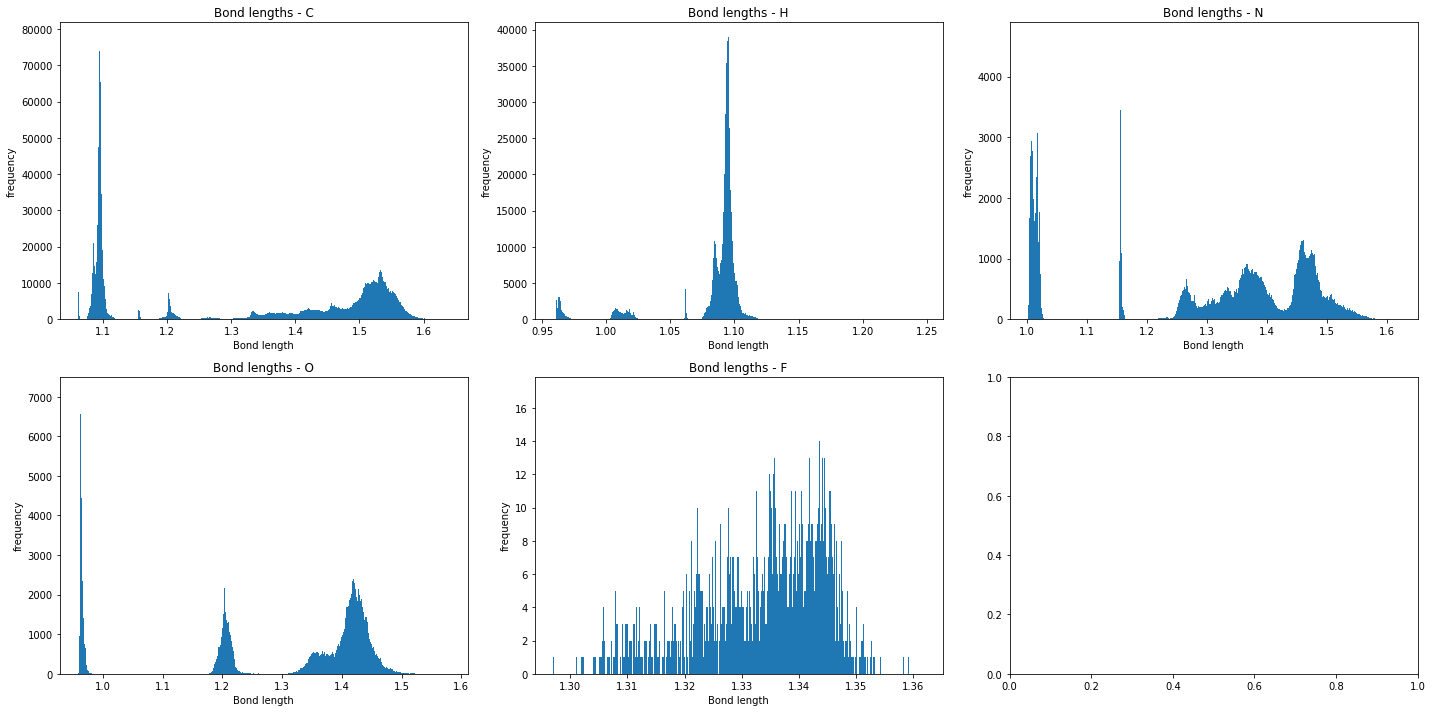

In [50]:
elements = structures['atom'].unique()
graphs_per_row = 3
row_count = int(np.ceil(len(elements) / graphs_per_row))
fig, axes = plt.subplots(row_count, graphs_per_row, figsize=(20, row_count * 5))

for i, element in enumerate(elements):
    y = []
    for l in structures[structures['atom'] == element]['bond_lengths'].values:
        y.extend(l)
    ax = axes[i//graphs_per_row, i%graphs_per_row]
    ax.hist(y, bins=1000)
    ax.set(title=f'Bond lengths - {element}', xlabel='Bond length', ylabel='frequency')

plt.tight_layout()
plt.show()